In [125]:
!pip install spacy
!python -m spacy download en_core_web_sm

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [68]:

#  O my body, make of me always a man who questions!

import spacy
import re
import pandas as pd
import numpy as np
import requests
from spacy.matcher import Matcher 

import networkx as nx

import matplotlib.pyplot as plt

from common import *

nlp = spacy.load('en_core_web_sm')

pd.set_option('display.max_colwidth', 200)
%matplotlib inline


In [69]:
book = read_file('data/Strang-Linear Algebra.txt')

In [70]:
def sentence_fits(s):
    """Check if sentence contains only one subject and one object"""
    deps = ''.join([token.dep_ for token in nlp(s)])
    return deps.count('obj') == 1 & deps.count('subj') == 1
    

In [71]:
chapter = get_one_chapter(4, book)

sentences = [i for i in chapter ]#if sentence_fits(i)]
sentences[:25]

['Determinants are much further from the center of linear algebra than they were a hundred years ago.',
 'Mathematics keeps changing direction! After all, a single number can tell only so much about a matrix.',
 'Still, it is amazing how much this number can do.',
 'One viewpoint is this: The determinant provides an explicit formula for each entry of A.1 and A.1b.',
 'This formula will not change the way we compute; even the determinant itself is found by elimination.',
 'In fact, elimination can be regarded as the most efficient way to substitute the entries of an n by n matrix into the formula.',
 'What the formula does is to show how A.1 depends on the n2 entries of A, and how it varies when those entries vary.',
 'We can list four of the main uses of determinants: 1.',
 'They test for invertibility.',
 'If the determinant of A is zero, then A is singular.',
 'If detA 6= 0, then A is invertible (and A.1 involves 1=detA). The most important application, and the reason this chapter is

In [72]:
def get_relation(sent):
    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", None, pattern) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)


In [73]:
relations = [get_relation(i) for i in sentences]
pd.Series(relations).value_counts()[:25]

is                  67
has                 23
are                 14
Find                 7
1                    7
gives                7
Determinants         6
Example              5
Suppose              5
give                 5
find                 4
is singular          4
prove                4
3                    4
detA.                4
Compute              4
be                   4
know                 4
34                   3
75                   3
have determinant     3
10                   3
20                   3
2                    3
Applications of      3
dtype: int64

In [74]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""

    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""      

            ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text

            ## chunk 5  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text

    return [ent1.replace('  ', ' ').strip(), ent2.replace('  ', ' ').strip()]


In [75]:
objects = [''] * len(sentences)
subjects = [''] * len(sentences)

for i, s in enumerate(sentences):
    subjects[i], objects[i] = get_entities(s)
    
subjects = np.array(subjects)
objects = np.array(objects)

subjects[:25]

array(['much linear they', 'single number', 'how number', 'determinant',
       'even determinant', 'elimination', 'when entries', 'We', 'They',
       'then A', 'chapter', 'I', 'test', 'polynomial', 'that',
       'determinant', 'edges', 'columns', 'simplest box', 'we',
       'single volume element', '1 value', 'straighter edges',
       'determinant', 'pivot entry'], dtype='<U35')

In [76]:
kg_df = pd.DataFrame({'source':subjects, 'target':objects, 'link':relations})
kg_df.head()

,source,target,link
0,much linear they,much linear algebra,are
1,single number,so matrix,tell
2,how number,how much,is amazing
3,determinant,explicit A.1,provides
4,even determinant,elimination,found by


In [77]:
G = nx.from_pandas_edgelist(kg_df, 'source', 'target', 
                            edge_attr=True, create_using=nx.MultiDiGraph())


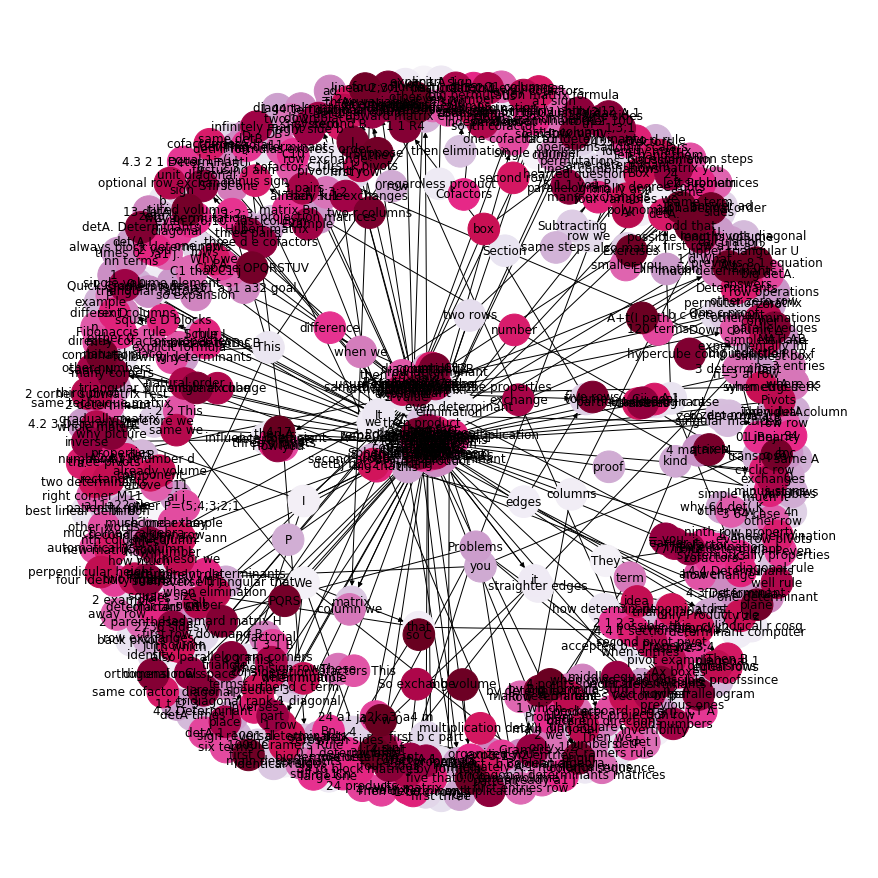

In [78]:
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_size=1000, node_color=range(G.number_of_nodes()), 
        pos=pos, cmap=plt.cm.PuRd)
plt.show()


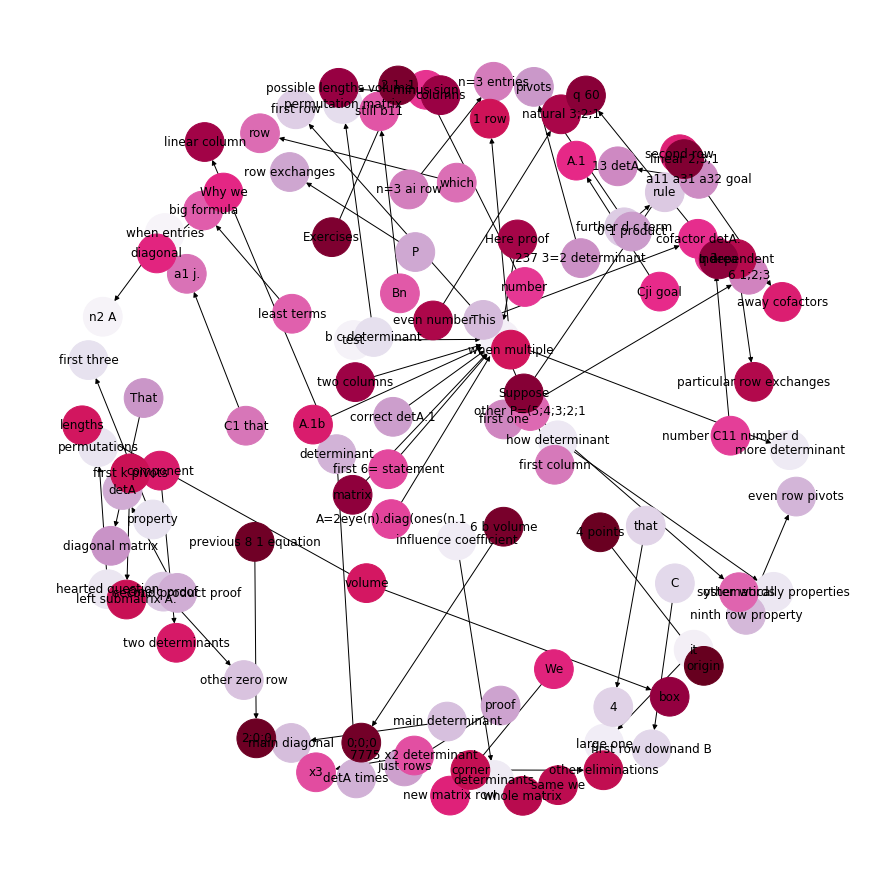

In [79]:
G_smol = nx.from_pandas_edgelist(kg_df[kg_df['link']=="is"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G_smol, k=.4)
nx.draw(G_smol, with_labels=True, node_color=range(G_smol.number_of_nodes()), 
        node_size=1500, cmap=plt.cm.PuRd, pos=pos)
plt.show()


In [80]:
# Adding weights to graph edges for better question selection
popukarity = dict(G.out_degree())
popukarity

{'much linear they': 1,
 'much linear algebra': 0,
 'single number': 1,
 'so matrix': 0,
 'how number': 1,
 'how much': 0,
 'determinant': 18,
 'explicit A.1': 0,
 'even determinant': 1,
 'elimination': 3,
 'by formula': 0,
 'when entries': 1,
 'n2 A': 0,
 'We': 7,
 'main determinants': 0,
 'They': 3,
 'invertibility': 0,
 'then A': 1,
 'A': 5,
 'chapter': 1,
 'matrices': 1,
 'I': 5,
 'which': 3,
 'test': 1,
 '': 83,
 'polynomial': 1,
 'n degree roots': 0,
 'that': 3,
 'determinant computer': 0,
 'dimensional space': 0,
 'edges': 3,
 'columns': 3,
 'same volume': 0,
 'simplest box': 1,
 'little RRR f': 0,
 'we': 4,
 'cylindrical r cosq': 0,
 'single volume element': 1,
 'single integralso': 0,
 '1 value': 1,
 'straighter edges': 1,
 'it': 5,
 'pivot': 0,
 'pivot entry': 1,
 'row exchange': 0,
 'regardless product': 1,
 'apart sign': 0,
 'small pivot': 1,
 'us': 0,
 'large one': 0,
 'back it': 1,
 'numerical ruins': 0,
 'b.': 0,
 'influence coefficient': 1,
 'determinants': 1,
 'more de

In [81]:
for u,v,d in G.edges(data=True):
    d['weight'] = popukarity[u] + popukarity[v]  # weight is the the sum of outdegrees of the vertices connected by the edge


In [82]:
indexes = np.flip(np.argsort(np.array([x[2]['weight'] for x in G.edges(data=True)])))


In [83]:
def create_gap_filled_question(body, subject):
    question = body.replace(subject, '_' * len(subject))
    print(question)
    print('Answer:', subject)
    

In [84]:
sentences = np.array(sentences)
top_sentences = sentences[indexes]
top_sentences[:10]

array(['The determinant depends linearly on the first row.',
       'The only number which can do that is zero, so detA = 0. (The reasoning fails if 1 = .1, which is the case in Boolean algebra.',
       'Now come all other matrices! 3.',
       'Suppose A, B, C are the same from the second row downand row 1 of A is a linear combination of the first rows of B and C.',
       'Then the rule says: detA is the same combination of detB and detC.',
       'Linear combinations involve two operationsadding vectors and multiplying by scalars.',
       'Therefore this rule can be split into two parts: Add vectors in row 1 ..... a+a0 b+b0 c d ..... = ..... a b c d ..... + ..... a0 b0 c d ..... : Multiply by t in row 1 ..... ta tb c d ..... = t ..... a b c d ..... : Notice that the first part is not the false statement det(B+C) = detB+detC.',
       'Zero row ..... 0 0 c d ..... = 0: One proof is to add some other row to the zero row.',
       'If A has a row of zeros, then detA = 0.',
       'Th

In [92]:
create_gap_filled_question(top_sentences[8], subjects[indexes[8]])

If _ has a row of zeros, then det_ = 0.
Answer: A


In [86]:
unique, counts = np.unique(subjects, return_counts=True)
np.asarray((unique, counts)).T

array([['', '83'],
       ['0 1 determinants', '1'],
       ['0 1 product', '1'],
       ['0 Linearity', '1'],
       ['0 row', '1'],
       ['1 1;3;2', '1'],
       ['1 3 1 B', '1'],
       ['1 P', '1'],
       ['1 d What', '1'],
       ['1 entries', '1'],
       ['1 number', '1'],
       ['1 rule', '1'],
       ['1 value', '1'],
       ['1 which', '1'],
       ['1000 Cramers Rule', '1'],
       ['120 terms', '1'],
       ['2 1 2 3', '1'],
       ['2 2 This', '1'],
       ['2 4 2 MATLAB', '1'],
       ['2 corner submatrix rest', '1'],
       ['2 we', '1'],
       ['2 you', '1'],
       ['237 3=2 determinant', '1'],
       ['24 a1 ja2ka3`a4 m', '1'],
       ['24 terms', '1'],
       ['3 2 denominators', '1'],
       ['3 determinant', '2'],
       ['3 matrices', '1'],
       ['3 pairs', '1'],
       ['4', '2'],
       ['4 matrix M', '1'],
       ['4 points', '1'],
       ['4 that', '1'],
       ['4 v w 0', '1'],
       ['4.17', '1'],
       ['4.2 This', '1'],
       ['4.3 areas', '1'],


In [ ]:
# TODO: The entities mentioned in the question’s clues should not contain tokens that
#overlap with the answer entity (e.g., A fact asking about Leonardo da Vinci’s
#birthplace Vinci, Florence should be filtered out).
